In [42]:
import numpy as np
import pandas
from nltk.corpus import stopwords
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import scale
from keras.preprocessing import text
import pdb
from progressbar import progressbar

STOPSET_WORDS = ['might', 'may', 'would', 'must', 'lgtm', 'could', 'can', 'good', 'great', 'nice', 'well', 'better', 'worse', \
	'worst', 'should', 'i', "i'll", "ill", "it's", "its", "im", "i'm", "they're", "theyre", "you're", "youre", "that's", 'btw', \
	"thats", "theres", "shouldnt", "shouldn't", "didn't", "didnt", "dont", "don't", "doesn't", "doesnt", "wasnt", "wasn't", \
	'sense', "mon", 'monday', 'tue', 'wed', 'wednesday', 'thursday', 'thu', 'friday', 'fri', 'sat', 'saturday', 'sun', 'sunday', \
	'jan', 'january', 'feb', 'february', 'mar', 'march', 'apr', 'april', 'may', 'jun', 'june', 'july', 'jul', 'aug', 'august',\
	'sep', 'september', 'oct', 'october', 'nov', 'novenber', 'dec', 'december', 'pm', 'am'    
]

WIKI_WORDS = 'app/data/files/wiki-news-300d-1M.vec'
GLOVE_WORDS = 'app/data/files/glove.42B.300d.txt'
encoding="utf-8"
WORD_DICTIONARY = {}
print('Loading word-embedding file and making dictionary...')
for line in progressbar(open(WIKI_WORDS)):
    values = line.split()
    WORD_DICTIONARY[values[0]] = np.array(values[1:], dtype='float32')
print('Word-embedding file loaded successfully')

# token = text.Tokenizer()
# token.fit_on_texts(trainDF['text'])
# word_index = token.word_index

def normalize(np_array):
	np_array = scale(np_array, axis=0, with_mean=True, with_std=True, copy=True)
	min = np_array.min()
	max = np_array.max()
	if(max == 0 and min == 0):
		return np_array
	return (np_array - min) / (max - min)

def word_embed(data):
    # load the pre-trained word-embedding vectors 
    word_vector = np.zeros(np.array((data.shape[0], 300)))
    i = 0
    print('embedding word and converting to vector...')
    for sentence in data['text']:
        words = sentence.split()
        # length = len(words)
        for word in words:
                if word in WORD_DICTIONARY:
                        word_vector[i] = np.add(word_vector[i], WORD_DICTIONARY[word])
        word_vector[i] = normalize(word_vector[i])                
        i += 1
    return word_vector
    # token = text.Tokenizer()
    # token.fit_on_texts(data['text'])
    # word_index = token.word_index
    # # word_vector = sequence.pad_sequences(token.texts_to_sequences(data), maxlen=70)
    # embedding_matrix = np.zeros((len(word_index) + 1, 300))
    # for word, i in word_index.items():
    #     embedding_vector = WORD_DICTIONARY.get(word)
    #     if embedding_vector is not None:
    #         embedding_matrix[i] = embedding_vector
    # pdb.set_trace()        
    # return embedding_matrix

def input_file_path(url):
	return url.strip()

def structure(data_file_path):
	data = pandas.read_csv(data_file_path, sep=",", header=None, names=['text', 'label'])
	return data

def remove_stopwords(data):
	stopset = set(stopwords.words('english'))
	for word in STOPSET_WORDS:
		stopset.add(word) 
	
	data['text'] = data['text'].apply(lambda sentence: ' '.join([word for word in sentence.lower().split() if word not in (stopset)]))
	return data

def process(data_url):
	return remove_stopwords(structure(input_file_path(data_url)))		

def data_for_evaluation(data, test_size_for_split):
	train_data, test_data, train_label, test_label = model_selection.train_test_split(data['text'], data['label'], test_size=test_size_for_split, random_state=0)
	return train_data, test_data, train_label, test_label

def count_vectorize(data, train_data, test_data):
	count_vector = CountVectorizer(analyzer = 'word', token_pattern = r'\w{1,}')
	count_vector.fit(data['text'])

	train_data_count = count_vector.transform(train_data)
	test_data_count = count_vector.transform(test_data)

	# train_data_count = word_embed(train_data)
	# test_data_count = word_embed(test_data)

	# print('word embedding is complete!')

	return train_data_count, test_data_count

def count_vectorizer(data):
	count_vect = CountVectorizer()
	train_data_count = count_vect.fit_transform(data['text'])
	
	return train_data_count

def tf_idf_vectorize(data, train_data, test_data):
	tf_idf_vector = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range= (2,3), max_features=5000)
	tf_idf_vector.fit(data['text'])
	train_data_tf_idf =  tf_idf_vector.transform(train_data)
	test_data_tf_idf =  tf_idf_vector.transform(test_data)

	return train_data_tf_idf, test_data_tf_idf

def tf_idf_vectorizer(data):
	tf_idf_vector = TfidfVectorizer()
	train_data_tf_idf = tf_idf_vector.fit_transform(data['text'])
	
	return train_data_tf_idf			

def encode_target_variable(train_label, test_label):
	encoder = preprocessing.LabelEncoder()
	train_label = encoder.fit_transform(train_label)
	test_label = encoder.fit_transform(test_label)
	return train_label, test_label		

- | #                                              | 1202 Elapsed Time: 0:00:00

Loading word-embedding file and making dictionary...


| |     #                                        | 999994 Elapsed Time: 0:01:23


Word-embedding file loaded successfully


In [43]:
# Trainer
def train(classifier, train_data, train_label, is_neural_net=False):
    
    # fit the training dataset on the classifier
    trained_classifier = classifier.fit(train_data, train_label)
    return trained_classifier

In [44]:
# Verifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def split_verifier(trained_classifier, test_data, test_label):
	predictions = trained_classifier.predict(test_data)
	return round(metrics.accuracy_score(predictions, test_label), 4)

def cross_verifier(classifier, text, label, n):
	result_array = cross_val_score(classifier, text, label, cv=n)
	result = sum(result_array) / n	
	return result_array, round(result, 4)

In [45]:
from sklearn import tree, naive_bayes, ensemble, svm, linear_model

def split_validation(data, test_size_for_split, classifier):
	train_data, test_data, train_label, test_label = data_for_evaluation(data, test_size_for_split)

	train_data_count, test_data_count = count_vectorize(data, train_data, test_data)
	train_data_tf_idf, test_data_tf_idf = tf_idf_vectorize(data, train_data, test_data)

	trained_classifier_with_count = train(classifier, train_data_count, train_label)
	trained_classifier_with_tf_idf = train(classifier, train_data_tf_idf, train_label)

	result_with_count = split_verifier(trained_classifier_with_count, test_data_count, test_label)
	result_with_tf_idf = split_verifier(trained_classifier_with_tf_idf, test_data_tf_idf, test_label)

	return result_with_count, result_with_tf_idf

def cross_verification(data, feature_vectors, classifier, n):
	count_resut_array, count_result = cross_verifier(classifier, feature_vectors['count'], data['label'], n)
	tf_idf_result_array, tf_idf_result = cross_verifier(classifier, feature_vectors['tf-idf'], data['label'], n)
	word_embedd_result_array, word_embedd_result = cross_verifier(classifier, feature_vectors['word-embedd'], data['label'], n)
	return count_result, tf_idf_result, word_embedd_result

In [46]:
import re

ALGORITHMS = ['Decision Tree', 'Random Forest', 'Naive Bayes', 'SVM', 'Logistic Regression']
VERIFICATION_METHODS = ['Split', 'Cross']
FEATURE_VECTORS = ['Count', 'TF-IDF', 'Word Embedd']


def ctk(value):
	key = value.lower()
	return re.sub(" ", "_", key)

def initialize():
	result = {
		'algorithms': {
		}
	}
	for a in ALGORITHMS:
		result['algorithms'].update([(ctk(a), {})])
		result['algorithms'][ctk(a)].update([('display_name', a), ('verification_methods', {} )])
		for b in VERIFICATION_METHODS:
			result['algorithms'][ctk(a)]['verification_methods'].update([(ctk(b), {})])
			result['algorithms'][ctk(a)]['verification_methods'][ctk(b)].update([('display_name', b),('feature_vectors', {})])
			for c in FEATURE_VECTORS:
				result['algorithms'][ctk(a)]['verification_methods'][ctk(b)]['feature_vectors'].update([(ctk(c), {})])
				result['algorithms'][ctk(a)]['verification_methods'][ctk(b)]['feature_vectors'][ctk(c)].update([('display_name', c), ('value', 0)])

	return result

In [47]:
from prettytable import PrettyTable

def represent(result):
	table = PrettyTable()
	table.field_names = ['', 'Count', 'TF-IDF', 'Word Embedding']
	for algo in result['algorithms']:
		row = [(result['algorithms'][algo]['display_name'])]
		for vt in result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']:
			row.append(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors'][vt]['value'])
		table.add_row(row)
	
	print(table)

In [48]:
import matplotlib.pyplot as plt

def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/3, 1.05*height, height, ha='center', va='bottom')        

def show_graph(result):
	fig = plt.figure(1)

	algorithm_names = []
	feature_names = ['Count', 'TF-IDF', 'Word Embedd'] 
	for algo in result['algorithms']:
		algorithm_names.append(result['algorithms'][algo]['display_name'])	

	N = len(result['algorithms'])
	ind = np.arange(N) 
	width = .20

	ax_2 = fig.subplots()
	count_vectors = []
	for algo in result['algorithms']:
		count_vectors.append(round(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']['count']['value'], 2))       

	rects1 = ax_2.bar(ind, count_vectors, width, color='b')

	tf_idf_vectors = []
	for algo in result['algorithms']:
		tf_idf_vectors.append(round(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], 2))

	rects2 = ax_2.bar(ind + width, tf_idf_vectors, width, color='g')

	word_vectors = []
	for algo in result['algorithms']:
		word_vectors.append(round(result['algorithms'][algo]['verification_methods']['cross']['feature_vectors']['word_embedd']['value'], 2))

	rects3 = ax_2.bar(ind + width + width, word_vectors, width, color='r')

	ax_2.set_ylabel('Accuracy')
	# ax_2.set_xlabel('Algotithms grouped by feature of data')
	ax_2.set_title('Accuracy using cross verification')
	ax_2.set_xticks(ind + width + width / 3 )
	ax_2.set_xticklabels(algorithm_names)

	ax_2.legend((rects1[0], rects2[0], rects3[0]), feature_names)

	autolabel(rects1, ax_2)
	autolabel(rects2, ax_2)
	autolabel(rects3, ax_2)

	plt.show()

In [49]:
def verify(data, n):

	result = initialize()
	feature_vectors = {}
	feature_vectors['count'] = count_vectorizer(data)
	feature_vectors['tf-idf'] = tf_idf_vectorizer(data)
	feature_vectors['word-embedd'] = word_embed(data)

	#Cross Verification
	result['algorithms']['decision_tree']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['decision_tree']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], \
	result['algorithms']['decision_tree']['verification_methods']['cross']['feature_vectors']['word_embedd']['value'] = \
	cross_verification(data, feature_vectors, tree.DecisionTreeClassifier(), n)

	result['algorithms']['random_forest']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['random_forest']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], \
	result['algorithms']['random_forest']['verification_methods']['cross']['feature_vectors']['word_embedd']['value'] = \
	cross_verification(data, feature_vectors, ensemble.RandomForestClassifier(), n)

	result['algorithms']['naive_bayes']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['naive_bayes']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], \
	result['algorithms']['naive_bayes']['verification_methods']['cross']['feature_vectors']['word_embedd']['value'] = \
	cross_verification(data, feature_vectors, naive_bayes.MultinomialNB(), n)

	result['algorithms']['svm']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['svm']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], \
	result['algorithms']['svm']['verification_methods']['cross']['feature_vectors']['word_embedd']['value'] = \
	cross_verification(data, feature_vectors, svm.SVC(), n)

	result['algorithms']['logistic_regression']['verification_methods']['cross']['feature_vectors']['count']['value'], \
	result['algorithms']['logistic_regression']['verification_methods']['cross']['feature_vectors']['tf-idf']['value'], \
	result['algorithms']['logistic_regression']['verification_methods']['cross']['feature_vectors']['word_embedd']['value'] = \
	cross_verification(data, feature_vectors, linear_model.LogisticRegression(), n)
	represent(result), show_graph(result)

embedding word and converting to vector...
+---------------------+--------+--------+----------------+
|                     | Count  | TF-IDF | Word Embedding |
+---------------------+--------+--------+----------------+
|    Decision Tree    | 0.8272 |  0.84  |     0.6991     |
|    Random Forest    | 0.8468 | 0.828  |     0.795      |
|     Naive Bayes     | 0.8223 | 0.8099 |     0.754      |
|         SVM         | 0.754  | 0.754  |     0.754      |
| Logistic Regression | 0.8498 |  0.79  |     0.8469     |
+---------------------+--------+--------+----------------+


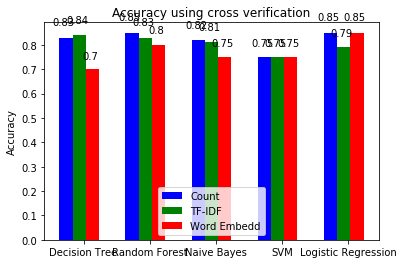

In [50]:
import warnings

warnings.filterwarnings("ignore")

data_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vSGhxSbBeeXdkRdBVQ9wSL1aJTs52SXV3NKfcfoX1wI89XDCJMC5tW0HZk5HYdh2xT0DtufMLSn9hHX/pub?gid=1193567183&single=true&output=csv"
# data_url = 'file:///Users/nernst/Documents/projects/design-detect/minEval/data/brunet.csv'
data = process(data_url)

verify(data, 10) ## data, test_size_for_split, k_fold_for_cross